# Inception v3 (Exercise 11-1)
Exercise Sung Kim lesson 11: Advanced CNN<br>
https://arxiv.org/abs/1602.07261<br>
Secret Sauce: `git@github.com:Cadene/pretrained-models.pytorch.git`<br>
He has well defined `stride and padding`!<br>
Test with CIFAR-10. Because it is small dataset and I have base line at 98% or more accuracy

## Smallest possible size is (150, 150, 3)
Watch out CIFAR-10 is 32x32. Then `PyTorch` will raise `std::exception`<br>
https://stackoverflow.com/questions/42522006/how-to-input-cifar10-into-inceptionv3-in-keras

In [31]:
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(151)
use_cuda = torch.cuda.is_available()
device = 'cpu'

In [32]:
use_cuda

False

In [40]:
print('==> Preparing data..')
transform_data = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_data)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


# Show some training images, for fun

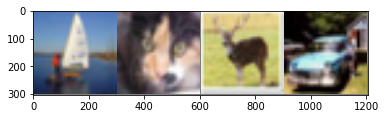

 ship   cat  deer   car


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [21]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[0], target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

            # https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
            # Prevent system reboot
            state = {
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(state, 'savepoint.pth.tar')
            
            # Pray that I don't need to use them
            #model.load_state_dict(state['state_dict'])
            #optimizer.load_state_dict(state['optimizer'])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_test += list(target)
            y_pred += list(pred.view_as(target))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=classes, normalize=True,
                          title='Normalized confusion matrix')


# 1. Model

Use ready-made from [`PyTorch`](https://pytorch.org/docs/stable/_modules/torchvision/models/inception.html#inception_v3)

In [66]:
from torchvision.models import Inception3
model = Inception3(num_classes=10, transform_input=True)

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [67]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', trainloader, optimizer, epoch, criterion)
    test(model, 'cpu', testloader, criterion)




  0%|          | 0/12500 [00:00<?, ?it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.446244





  0%|          | 1/12500 [00:02<8:11:20,  2.36s/it]


  0%|          | 2/12500 [00:03<7:08:39,  2.06s/it]


  0%|          | 3/12500 [00:04<6:17:56,  1.81s/it]


  0%|          | 4/12500 [00:06<5:44:50,  1.66s/it]


  0%|          | 5/12500 [00:07<5:20:38,  1.54s/it]


  0%|          | 6/12500 [00:08<4:59:59,  1.44s/it]Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/cond

KeyboardInterrupt: 





  0%|          | 0/2500 [00:00<?, ?it/s]



  0%|          | 1/2500 [00:00<25:52,  1.61it/s]



  0%|          | 2/2500 [00:00<22:36,  1.84it/s]



  0%|          | 3/2500 [00:01<20:59,  1.98it/s]



  0%|          | 4/2500 [00:01<19:52,  2.09it/s]



  0%|          | 5/2500 [00:02<18:21,  2.27it/s]



  0%|          | 6/2500 [00:02<17:23,  2.39it/s]



  0%|          | 7/2500 [00:02<16:36,  2.50it/s]



  0%|          | 8/2500 [00:03<16:14,  2.56it/s]



  0%|          | 9/2500 [00:03<16:19,  2.54it/s]



  0%|          | 10/2500 [00:04<17:16,  2.40it/s]



  0%|          | 11/2500 [00:04<16:42,  2.48it/s]



  0%|          | 12/2500 [00:04<16:21,  2.54it/s]



  1%|          | 13/2500 [00:05<16:04,  2.58it/s]



  1%|          | 14/2500 [00:05<15:55,  2.60it/s]



  1%|          | 15/2500 [00:06<15:50,  2.61it/s]



  1%|          | 16/2500 [00:06<16:48,  2.46it/s]



  1%|          | 17/2500 [00:06<16:18,  2.54it/s]



  1%|          | 18/2500 [00:07<16:04,  2.57it/s]



  1%|  

  5%|▌         | 125/2500 [00:48<14:26,  2.74it/s]



  5%|▌         | 126/2500 [00:48<14:25,  2.74it/s]



  5%|▌         | 127/2500 [00:49<15:54,  2.49it/s]



  5%|▌         | 128/2500 [00:49<15:22,  2.57it/s]



  5%|▌         | 129/2500 [00:49<14:59,  2.64it/s]



  5%|▌         | 130/2500 [00:50<14:43,  2.68it/s]



  5%|▌         | 131/2500 [00:50<14:46,  2.67it/s]



  5%|▌         | 132/2500 [00:51<14:44,  2.68it/s]



  5%|▌         | 133/2500 [00:51<16:25,  2.40it/s]



  5%|▌         | 134/2500 [00:51<16:13,  2.43it/s]



  5%|▌         | 135/2500 [00:52<15:44,  2.50it/s]



  5%|▌         | 136/2500 [00:52<15:24,  2.56it/s]



  5%|▌         | 137/2500 [00:53<15:10,  2.59it/s]



  6%|▌         | 138/2500 [00:53<15:04,  2.61it/s]



  6%|▌         | 139/2500 [00:53<16:09,  2.44it/s]



  6%|▌         | 140/2500 [00:54<15:31,  2.53it/s]



  6%|▌         | 141/2500 [00:54<15:03,  2.61it/s]



  6%|▌         | 142/2500 [00:55<14:45,  2.66it/s]



  6%|▌         | 143/2500 [0

 10%|▉         | 249/2500 [01:35<14:19,  2.62it/s]



 10%|█         | 250/2500 [01:36<14:15,  2.63it/s]



 10%|█         | 251/2500 [01:36<15:20,  2.44it/s]



 10%|█         | 252/2500 [01:37<15:02,  2.49it/s]



 10%|█         | 253/2500 [01:37<14:44,  2.54it/s]



 10%|█         | 254/2500 [01:37<14:29,  2.58it/s]



 10%|█         | 255/2500 [01:38<14:30,  2.58it/s]



 10%|█         | 256/2500 [01:38<14:34,  2.57it/s]



 10%|█         | 257/2500 [01:39<15:25,  2.42it/s]



 10%|█         | 258/2500 [01:39<14:57,  2.50it/s]



 10%|█         | 259/2500 [01:39<14:38,  2.55it/s]



 10%|█         | 260/2500 [01:40<14:24,  2.59it/s]



 10%|█         | 261/2500 [01:40<14:16,  2.61it/s]



 10%|█         | 262/2500 [01:41<14:10,  2.63it/s]



 11%|█         | 263/2500 [01:41<15:42,  2.37it/s]



 11%|█         | 264/2500 [01:41<14:58,  2.49it/s]



 11%|█         | 265/2500 [01:42<14:29,  2.57it/s]



 11%|█         | 266/2500 [01:42<14:07,  2.64it/s]



 11%|█         | 267/2500 [0

 15%|█▍        | 373/2500 [02:23<13:15,  2.68it/s]



 15%|█▍        | 374/2500 [02:24<13:20,  2.66it/s]



 15%|█▌        | 375/2500 [02:24<14:28,  2.45it/s]



 15%|█▌        | 376/2500 [02:24<13:56,  2.54it/s]



 15%|█▌        | 377/2500 [02:25<13:31,  2.61it/s]



 15%|█▌        | 378/2500 [02:25<13:14,  2.67it/s]



 15%|█▌        | 379/2500 [02:25<13:02,  2.71it/s]



 15%|█▌        | 380/2500 [02:26<12:57,  2.73it/s]



 15%|█▌        | 381/2500 [02:26<14:10,  2.49it/s]



 15%|█▌        | 382/2500 [02:27<13:57,  2.53it/s]



 15%|█▌        | 383/2500 [02:27<13:46,  2.56it/s]



 15%|█▌        | 384/2500 [02:27<13:34,  2.60it/s]



 15%|█▌        | 385/2500 [02:28<13:30,  2.61it/s]



 15%|█▌        | 386/2500 [02:28<13:23,  2.63it/s]



 15%|█▌        | 387/2500 [02:29<14:23,  2.45it/s]



 16%|█▌        | 388/2500 [02:29<14:00,  2.51it/s]



 16%|█▌        | 389/2500 [02:29<13:48,  2.55it/s]



 16%|█▌        | 390/2500 [02:30<13:34,  2.59it/s]



 16%|█▌        | 391/2500 [0

 20%|█▉        | 497/2500 [03:11<12:13,  2.73it/s]



 20%|█▉        | 498/2500 [03:11<12:12,  2.73it/s]



 20%|█▉        | 499/2500 [03:12<13:17,  2.51it/s]



 20%|██        | 500/2500 [03:12<12:51,  2.59it/s]



 20%|██        | 501/2500 [03:12<12:33,  2.65it/s]



 20%|██        | 502/2500 [03:13<12:20,  2.70it/s]



 20%|██        | 503/2500 [03:13<12:12,  2.73it/s]



 20%|██        | 504/2500 [03:13<12:07,  2.74it/s]



 20%|██        | 505/2500 [03:14<13:24,  2.48it/s]



 20%|██        | 506/2500 [03:14<12:55,  2.57it/s]



 20%|██        | 507/2500 [03:15<12:37,  2.63it/s]



 20%|██        | 508/2500 [03:15<12:23,  2.68it/s]



 20%|██        | 509/2500 [03:15<12:12,  2.72it/s]



 20%|██        | 510/2500 [03:16<12:05,  2.74it/s]



 20%|██        | 511/2500 [03:16<12:50,  2.58it/s]



 20%|██        | 512/2500 [03:17<13:04,  2.54it/s]



 21%|██        | 513/2500 [03:17<12:40,  2.61it/s]



 21%|██        | 514/2500 [03:17<12:24,  2.67it/s]



 21%|██        | 515/2500 [0

 25%|██▍       | 621/2500 [03:59<11:35,  2.70it/s]



 25%|██▍       | 622/2500 [03:59<12:47,  2.45it/s]



 25%|██▍       | 623/2500 [04:00<12:28,  2.51it/s]



 25%|██▍       | 624/2500 [04:00<12:12,  2.56it/s]



 25%|██▌       | 625/2500 [04:00<12:03,  2.59it/s]



 25%|██▌       | 626/2500 [04:01<11:50,  2.64it/s]



 25%|██▌       | 627/2500 [04:01<11:45,  2.66it/s]



 25%|██▌       | 628/2500 [04:02<13:06,  2.38it/s]



 25%|██▌       | 629/2500 [04:02<12:31,  2.49it/s]



 25%|██▌       | 630/2500 [04:02<12:06,  2.57it/s]



 25%|██▌       | 631/2500 [04:03<11:48,  2.64it/s]



 25%|██▌       | 632/2500 [04:03<11:35,  2.68it/s]



 25%|██▌       | 633/2500 [04:03<11:28,  2.71it/s]



 25%|██▌       | 634/2500 [04:04<12:27,  2.50it/s]



 25%|██▌       | 635/2500 [04:04<12:20,  2.52it/s]



 25%|██▌       | 636/2500 [04:05<11:58,  2.60it/s]



 25%|██▌       | 637/2500 [04:05<11:43,  2.65it/s]



 26%|██▌       | 638/2500 [04:05<11:31,  2.69it/s]



 26%|██▌       | 639/2500 [0

 30%|██▉       | 745/2500 [04:46<10:45,  2.72it/s]



 30%|██▉       | 746/2500 [04:47<12:00,  2.43it/s]



 30%|██▉       | 747/2500 [04:47<11:32,  2.53it/s]



 30%|██▉       | 748/2500 [04:48<11:12,  2.61it/s]



 30%|██▉       | 749/2500 [04:48<10:58,  2.66it/s]



 30%|███       | 750/2500 [04:48<10:48,  2.70it/s]



 30%|███       | 751/2500 [04:49<10:40,  2.73it/s]



 30%|███       | 752/2500 [04:49<11:50,  2.46it/s]



 30%|███       | 753/2500 [04:49<11:24,  2.55it/s]



 30%|███       | 754/2500 [04:50<11:06,  2.62it/s]



 30%|███       | 755/2500 [04:50<10:53,  2.67it/s]



 30%|███       | 756/2500 [04:51<10:45,  2.70it/s]



 30%|███       | 757/2500 [04:51<10:38,  2.73it/s]



 30%|███       | 758/2500 [04:51<11:19,  2.56it/s]



 30%|███       | 759/2500 [04:52<11:20,  2.56it/s]



 30%|███       | 760/2500 [04:52<11:02,  2.63it/s]



 30%|███       | 761/2500 [04:52<10:49,  2.68it/s]



 30%|███       | 762/2500 [04:53<10:40,  2.71it/s]



 31%|███       | 763/2500 [0

 35%|███▍      | 869/2500 [05:33<09:58,  2.72it/s]



 35%|███▍      | 870/2500 [05:34<09:53,  2.75it/s]



 35%|███▍      | 871/2500 [05:34<10:54,  2.49it/s]



 35%|███▍      | 872/2500 [05:35<10:32,  2.57it/s]



 35%|███▍      | 873/2500 [05:35<10:16,  2.64it/s]



 35%|███▍      | 874/2500 [05:35<10:05,  2.69it/s]



 35%|███▌      | 875/2500 [05:36<09:56,  2.72it/s]



 35%|███▌      | 876/2500 [05:36<10:05,  2.68it/s]



 35%|███▌      | 877/2500 [05:37<10:50,  2.50it/s]



 35%|███▌      | 878/2500 [05:37<10:47,  2.51it/s]



 35%|███▌      | 879/2500 [05:37<10:26,  2.59it/s]



 35%|███▌      | 880/2500 [05:38<10:12,  2.64it/s]



 35%|███▌      | 881/2500 [05:38<10:01,  2.69it/s]



 35%|███▌      | 882/2500 [05:38<09:53,  2.73it/s]



 35%|███▌      | 883/2500 [05:39<10:04,  2.67it/s]



 35%|███▌      | 884/2500 [05:39<10:38,  2.53it/s]



 35%|███▌      | 885/2500 [05:40<10:19,  2.61it/s]



 35%|███▌      | 886/2500 [05:40<10:06,  2.66it/s]



 35%|███▌      | 887/2500 [0

 40%|███▉      | 993/2500 [06:21<09:15,  2.71it/s]



 40%|███▉      | 994/2500 [06:21<09:09,  2.74it/s]



 40%|███▉      | 995/2500 [06:22<09:13,  2.72it/s]



 40%|███▉      | 996/2500 [06:22<09:58,  2.51it/s]



 40%|███▉      | 997/2500 [06:22<09:39,  2.59it/s]



 40%|███▉      | 998/2500 [06:23<09:25,  2.66it/s]



 40%|███▉      | 999/2500 [06:23<09:16,  2.70it/s]



 40%|████      | 1000/2500 [06:24<09:09,  2.73it/s]



 40%|████      | 1001/2500 [06:24<09:04,  2.75it/s]



 40%|████      | 1002/2500 [06:24<09:54,  2.52it/s]



 40%|████      | 1003/2500 [06:25<09:36,  2.60it/s]



 40%|████      | 1004/2500 [06:25<09:23,  2.66it/s]



 40%|████      | 1005/2500 [06:25<09:13,  2.70it/s]



 40%|████      | 1006/2500 [06:26<09:06,  2.73it/s]



 40%|████      | 1007/2500 [06:26<09:02,  2.75it/s]



 40%|████      | 1008/2500 [06:27<09:41,  2.57it/s]



 40%|████      | 1009/2500 [06:27<09:36,  2.59it/s]



 40%|████      | 1010/2500 [06:27<09:22,  2.65it/s]



 40%|████      | 

 45%|████▍     | 1115/2500 [07:07<09:10,  2.52it/s]



 45%|████▍     | 1116/2500 [07:08<08:52,  2.60it/s]



 45%|████▍     | 1117/2500 [07:08<08:40,  2.65it/s]



 45%|████▍     | 1118/2500 [07:08<08:32,  2.70it/s]



 45%|████▍     | 1119/2500 [07:09<08:26,  2.73it/s]



 45%|████▍     | 1120/2500 [07:09<08:21,  2.75it/s]



 45%|████▍     | 1121/2500 [07:10<09:07,  2.52it/s]



 45%|████▍     | 1122/2500 [07:10<08:49,  2.60it/s]



 45%|████▍     | 1123/2500 [07:10<08:38,  2.66it/s]



 45%|████▍     | 1124/2500 [07:11<08:29,  2.70it/s]



 45%|████▌     | 1125/2500 [07:11<08:23,  2.73it/s]



 45%|████▌     | 1126/2500 [07:11<08:18,  2.76it/s]



 45%|████▌     | 1127/2500 [07:12<08:53,  2.58it/s]



 45%|████▌     | 1128/2500 [07:12<08:53,  2.57it/s]



 45%|████▌     | 1129/2500 [07:12<08:40,  2.63it/s]



 45%|████▌     | 1130/2500 [07:13<08:29,  2.69it/s]



 45%|████▌     | 1131/2500 [07:13<08:23,  2.72it/s]



 45%|████▌     | 1132/2500 [07:14<08:28,  2.69it/s]



 45%|████▌

 49%|████▉     | 1237/2500 [07:53<07:57,  2.64it/s]



 50%|████▉     | 1238/2500 [07:54<07:49,  2.69it/s]



 50%|████▉     | 1239/2500 [07:54<07:43,  2.72it/s]



 50%|████▉     | 1240/2500 [07:55<08:30,  2.47it/s]



 50%|████▉     | 1241/2500 [07:55<08:12,  2.56it/s]



 50%|████▉     | 1242/2500 [07:55<07:58,  2.63it/s]



 50%|████▉     | 1243/2500 [07:56<07:49,  2.68it/s]



 50%|████▉     | 1244/2500 [07:56<07:43,  2.71it/s]



 50%|████▉     | 1245/2500 [07:56<07:39,  2.73it/s]



 50%|████▉     | 1246/2500 [07:57<08:05,  2.58it/s]



 50%|████▉     | 1247/2500 [07:57<08:10,  2.56it/s]



 50%|████▉     | 1248/2500 [07:58<08:11,  2.55it/s]



 50%|████▉     | 1249/2500 [07:58<08:04,  2.58it/s]



 50%|█████     | 1250/2500 [07:58<07:52,  2.65it/s]



 50%|█████     | 1251/2500 [07:59<07:46,  2.68it/s]



 50%|█████     | 1252/2500 [07:59<08:13,  2.53it/s]



 50%|█████     | 1253/2500 [08:00<08:30,  2.44it/s]



 50%|█████     | 1254/2500 [08:00<08:09,  2.54it/s]



 50%|█████

 54%|█████▍    | 1359/2500 [08:40<07:18,  2.60it/s]



 54%|█████▍    | 1360/2500 [08:40<07:28,  2.54it/s]



 54%|█████▍    | 1361/2500 [08:40<07:15,  2.62it/s]



 54%|█████▍    | 1362/2500 [08:41<07:05,  2.67it/s]



 55%|█████▍    | 1363/2500 [08:41<06:59,  2.71it/s]



 55%|█████▍    | 1364/2500 [08:42<06:55,  2.73it/s]



 55%|█████▍    | 1365/2500 [08:42<06:56,  2.73it/s]



 55%|█████▍    | 1366/2500 [08:42<07:32,  2.50it/s]



 55%|█████▍    | 1367/2500 [08:43<07:22,  2.56it/s]



 55%|█████▍    | 1368/2500 [08:43<07:16,  2.59it/s]



 55%|█████▍    | 1369/2500 [08:43<07:05,  2.66it/s]



 55%|█████▍    | 1370/2500 [08:44<06:57,  2.70it/s]



 55%|█████▍    | 1371/2500 [08:44<06:52,  2.73it/s]



 55%|█████▍    | 1372/2500 [08:45<07:39,  2.46it/s]



 55%|█████▍    | 1373/2500 [08:45<07:21,  2.55it/s]



 55%|█████▍    | 1374/2500 [08:45<07:08,  2.63it/s]



 55%|█████▌    | 1375/2500 [08:46<07:00,  2.68it/s]



 55%|█████▌    | 1376/2500 [08:46<06:55,  2.71it/s]



 55%|█████

 59%|█████▉    | 1481/2500 [09:27<06:13,  2.73it/s]



 59%|█████▉    | 1482/2500 [09:27<06:11,  2.74it/s]



 59%|█████▉    | 1483/2500 [09:28<06:45,  2.51it/s]



 59%|█████▉    | 1484/2500 [09:28<06:32,  2.59it/s]



 59%|█████▉    | 1485/2500 [09:28<06:22,  2.65it/s]



 59%|█████▉    | 1486/2500 [09:29<06:16,  2.69it/s]



 59%|█████▉    | 1487/2500 [09:29<06:11,  2.73it/s]



 60%|█████▉    | 1488/2500 [09:29<06:08,  2.75it/s]



 60%|█████▉    | 1489/2500 [09:30<06:36,  2.55it/s]



 60%|█████▉    | 1490/2500 [09:30<06:37,  2.54it/s]



 60%|█████▉    | 1491/2500 [09:31<06:26,  2.61it/s]



 60%|█████▉    | 1492/2500 [09:31<06:17,  2.67it/s]



 60%|█████▉    | 1493/2500 [09:31<06:11,  2.71it/s]



 60%|█████▉    | 1494/2500 [09:32<06:07,  2.74it/s]



 60%|█████▉    | 1495/2500 [09:32<06:23,  2.62it/s]



 60%|█████▉    | 1496/2500 [09:32<06:35,  2.54it/s]



 60%|█████▉    | 1497/2500 [09:33<06:33,  2.55it/s]



 60%|█████▉    | 1498/2500 [09:33<06:22,  2.62it/s]



 60%|█████

 64%|██████▍   | 1603/2500 [10:13<06:02,  2.48it/s]



 64%|██████▍   | 1604/2500 [10:14<05:53,  2.54it/s]



 64%|██████▍   | 1605/2500 [10:14<05:46,  2.58it/s]



 64%|██████▍   | 1606/2500 [10:14<05:38,  2.64it/s]



 64%|██████▍   | 1607/2500 [10:15<05:32,  2.69it/s]



 64%|██████▍   | 1608/2500 [10:15<06:00,  2.48it/s]



 64%|██████▍   | 1609/2500 [10:15<05:47,  2.57it/s]



 64%|██████▍   | 1610/2500 [10:16<05:38,  2.63it/s]



 64%|██████▍   | 1611/2500 [10:16<05:32,  2.68it/s]



 64%|██████▍   | 1612/2500 [10:17<05:27,  2.71it/s]



 65%|██████▍   | 1613/2500 [10:17<05:23,  2.74it/s]



 65%|██████▍   | 1614/2500 [10:17<05:39,  2.61it/s]



 65%|██████▍   | 1615/2500 [10:18<05:45,  2.56it/s]



 65%|██████▍   | 1616/2500 [10:18<05:41,  2.59it/s]



 65%|██████▍   | 1617/2500 [10:18<05:37,  2.62it/s]



 65%|██████▍   | 1618/2500 [10:19<05:34,  2.64it/s]



 65%|██████▍   | 1619/2500 [10:19<05:39,  2.59it/s]



 65%|██████▍   | 1620/2500 [10:20<05:59,  2.45it/s]



 65%|█████

 69%|██████▉   | 1725/2500 [11:00<04:57,  2.61it/s]



 69%|██████▉   | 1726/2500 [11:00<05:00,  2.58it/s]



 69%|██████▉   | 1727/2500 [11:01<04:52,  2.64it/s]



 69%|██████▉   | 1728/2500 [11:01<04:47,  2.69it/s]



 69%|██████▉   | 1729/2500 [11:02<04:43,  2.72it/s]



 69%|██████▉   | 1730/2500 [11:02<04:40,  2.75it/s]



 69%|██████▉   | 1731/2500 [11:02<04:43,  2.71it/s]



 69%|██████▉   | 1732/2500 [11:03<05:08,  2.49it/s]



 69%|██████▉   | 1733/2500 [11:03<04:57,  2.58it/s]



 69%|██████▉   | 1734/2500 [11:03<04:53,  2.61it/s]



 69%|██████▉   | 1735/2500 [11:04<04:52,  2.61it/s]



 69%|██████▉   | 1736/2500 [11:04<04:49,  2.64it/s]



 69%|██████▉   | 1737/2500 [11:05<04:50,  2.62it/s]



 70%|██████▉   | 1738/2500 [11:05<05:13,  2.43it/s]



 70%|██████▉   | 1739/2500 [11:05<05:00,  2.53it/s]



 70%|██████▉   | 1740/2500 [11:06<04:51,  2.61it/s]



 70%|██████▉   | 1741/2500 [11:06<04:45,  2.66it/s]



 70%|██████▉   | 1742/2500 [11:07<04:46,  2.64it/s]



 70%|█████

 74%|███████▍  | 1847/2500 [11:47<04:03,  2.68it/s]



 74%|███████▍  | 1848/2500 [11:47<04:00,  2.72it/s]



 74%|███████▍  | 1849/2500 [11:47<03:57,  2.74it/s]



 74%|███████▍  | 1850/2500 [11:48<04:20,  2.50it/s]



 74%|███████▍  | 1851/2500 [11:48<04:14,  2.55it/s]



 74%|███████▍  | 1852/2500 [11:49<04:07,  2.62it/s]



 74%|███████▍  | 1853/2500 [11:49<04:03,  2.66it/s]



 74%|███████▍  | 1854/2500 [11:49<03:58,  2.71it/s]



 74%|███████▍  | 1855/2500 [11:50<03:56,  2.73it/s]



 74%|███████▍  | 1856/2500 [11:50<04:08,  2.59it/s]



 74%|███████▍  | 1857/2500 [11:51<04:15,  2.52it/s]



 74%|███████▍  | 1858/2500 [11:51<04:07,  2.60it/s]



 74%|███████▍  | 1859/2500 [11:51<04:01,  2.65it/s]



 74%|███████▍  | 1860/2500 [11:52<03:57,  2.70it/s]



 74%|███████▍  | 1861/2500 [11:52<03:54,  2.72it/s]



 74%|███████▍  | 1862/2500 [11:52<03:54,  2.72it/s]



 75%|███████▍  | 1863/2500 [11:53<04:15,  2.50it/s]



 75%|███████▍  | 1864/2500 [11:53<04:09,  2.55it/s]



 75%|█████

 79%|███████▉  | 1969/2500 [12:34<03:27,  2.56it/s]



 79%|███████▉  | 1970/2500 [12:34<03:21,  2.63it/s]



 79%|███████▉  | 1971/2500 [12:34<03:18,  2.67it/s]



 79%|███████▉  | 1972/2500 [12:35<03:15,  2.70it/s]



 79%|███████▉  | 1973/2500 [12:35<03:26,  2.55it/s]



 79%|███████▉  | 1974/2500 [12:36<03:31,  2.49it/s]



 79%|███████▉  | 1975/2500 [12:36<03:24,  2.56it/s]



 79%|███████▉  | 1976/2500 [12:36<03:19,  2.63it/s]



 79%|███████▉  | 1977/2500 [12:37<03:15,  2.68it/s]



 79%|███████▉  | 1978/2500 [12:37<03:12,  2.72it/s]



 79%|███████▉  | 1979/2500 [12:37<03:12,  2.70it/s]



 79%|███████▉  | 1980/2500 [12:38<03:33,  2.43it/s]



 79%|███████▉  | 1981/2500 [12:38<03:24,  2.53it/s]



 79%|███████▉  | 1982/2500 [12:39<03:18,  2.61it/s]



 79%|███████▉  | 1983/2500 [12:39<03:14,  2.65it/s]



 79%|███████▉  | 1984/2500 [12:39<03:11,  2.70it/s]



 79%|███████▉  | 1985/2500 [12:40<03:08,  2.73it/s]



 79%|███████▉  | 1986/2500 [12:40<03:27,  2.48it/s]



 79%|█████

 84%|████████▎ | 2091/2500 [13:21<02:43,  2.51it/s]



 84%|████████▎ | 2092/2500 [13:21<02:38,  2.58it/s]



 84%|████████▎ | 2093/2500 [13:21<02:34,  2.64it/s]



 84%|████████▍ | 2094/2500 [13:22<02:31,  2.68it/s]



 84%|████████▍ | 2095/2500 [13:22<02:29,  2.72it/s]



 84%|████████▍ | 2096/2500 [13:22<02:27,  2.74it/s]



 84%|████████▍ | 2097/2500 [13:23<02:35,  2.59it/s]



 84%|████████▍ | 2098/2500 [13:23<02:38,  2.54it/s]



 84%|████████▍ | 2099/2500 [13:24<02:33,  2.61it/s]



 84%|████████▍ | 2100/2500 [13:24<02:30,  2.67it/s]



 84%|████████▍ | 2101/2500 [13:24<02:27,  2.71it/s]



 84%|████████▍ | 2102/2500 [13:25<02:25,  2.73it/s]



 84%|████████▍ | 2103/2500 [13:25<02:25,  2.73it/s]



 84%|████████▍ | 2104/2500 [13:25<02:38,  2.51it/s]



 84%|████████▍ | 2105/2500 [13:26<02:34,  2.56it/s]



 84%|████████▍ | 2106/2500 [13:26<02:32,  2.58it/s]



 84%|████████▍ | 2107/2500 [13:27<02:30,  2.61it/s]



 84%|████████▍ | 2108/2500 [13:27<02:28,  2.63it/s]



 84%|█████

 89%|████████▊ | 2213/2500 [14:07<01:46,  2.69it/s]



 89%|████████▊ | 2214/2500 [14:07<01:45,  2.72it/s]



 89%|████████▊ | 2215/2500 [14:08<01:44,  2.74it/s]



 89%|████████▊ | 2216/2500 [14:08<01:53,  2.50it/s]



 89%|████████▊ | 2217/2500 [14:09<01:50,  2.55it/s]



 89%|████████▊ | 2218/2500 [14:09<01:48,  2.61it/s]



 89%|████████▉ | 2219/2500 [14:09<01:46,  2.63it/s]



 89%|████████▉ | 2220/2500 [14:10<01:46,  2.64it/s]



 89%|████████▉ | 2221/2500 [14:10<01:46,  2.63it/s]



 89%|████████▉ | 2222/2500 [14:11<01:56,  2.38it/s]



 89%|████████▉ | 2223/2500 [14:11<01:52,  2.47it/s]



 89%|████████▉ | 2224/2500 [14:11<01:47,  2.56it/s]



 89%|████████▉ | 2225/2500 [14:12<01:44,  2.63it/s]



 89%|████████▉ | 2226/2500 [14:12<01:42,  2.68it/s]



 89%|████████▉ | 2227/2500 [14:12<01:40,  2.72it/s]



 89%|████████▉ | 2228/2500 [14:13<01:43,  2.62it/s]



 89%|████████▉ | 2229/2500 [14:13<01:47,  2.51it/s]



 89%|████████▉ | 2230/2500 [14:14<01:43,  2.60it/s]



 89%|█████

 93%|█████████▎| 2335/2500 [14:53<01:05,  2.54it/s]



 93%|█████████▎| 2336/2500 [14:54<01:05,  2.52it/s]



 93%|█████████▎| 2337/2500 [14:54<01:03,  2.56it/s]



 94%|█████████▎| 2338/2500 [14:55<01:02,  2.59it/s]



 94%|█████████▎| 2339/2500 [14:55<01:01,  2.61it/s]



 94%|█████████▎| 2340/2500 [14:55<01:00,  2.64it/s]



 94%|█████████▎| 2341/2500 [14:56<01:05,  2.43it/s]



 94%|█████████▎| 2342/2500 [14:56<01:03,  2.47it/s]



 94%|█████████▎| 2343/2500 [14:57<01:01,  2.56it/s]



 94%|█████████▍| 2344/2500 [14:57<00:59,  2.62it/s]



 94%|█████████▍| 2345/2500 [14:57<00:58,  2.67it/s]



 94%|█████████▍| 2346/2500 [14:58<00:56,  2.70it/s]



 94%|█████████▍| 2347/2500 [14:58<00:57,  2.64it/s]



 94%|█████████▍| 2348/2500 [14:58<01:00,  2.52it/s]



 94%|█████████▍| 2349/2500 [14:59<00:58,  2.60it/s]



 94%|█████████▍| 2350/2500 [14:59<00:56,  2.65it/s]



 94%|█████████▍| 2351/2500 [15:00<00:55,  2.69it/s]



 94%|█████████▍| 2352/2500 [15:00<00:54,  2.72it/s]



 94%|█████

 98%|█████████▊| 2457/2500 [15:40<00:16,  2.68it/s]



 98%|█████████▊| 2458/2500 [15:40<00:15,  2.72it/s]



 98%|█████████▊| 2459/2500 [15:41<00:14,  2.74it/s]



 98%|█████████▊| 2460/2500 [15:41<00:15,  2.51it/s]



 98%|█████████▊| 2461/2500 [15:41<00:15,  2.60it/s]



 98%|█████████▊| 2462/2500 [15:42<00:14,  2.66it/s]



 99%|█████████▊| 2463/2500 [15:42<00:13,  2.70it/s]



 99%|█████████▊| 2464/2500 [15:43<00:13,  2.73it/s]



 99%|█████████▊| 2465/2500 [15:43<00:12,  2.75it/s]



 99%|█████████▊| 2466/2500 [15:43<00:13,  2.54it/s]



 99%|█████████▊| 2467/2500 [15:44<00:12,  2.58it/s]



 99%|█████████▊| 2468/2500 [15:44<00:12,  2.64it/s]



 99%|█████████▉| 2469/2500 [15:44<00:11,  2.69it/s]



 99%|█████████▉| 2470/2500 [15:45<00:11,  2.72it/s]



 99%|█████████▉| 2471/2500 [15:45<00:10,  2.74it/s]



 99%|█████████▉| 2472/2500 [15:46<00:10,  2.61it/s]



 99%|█████████▉| 2473/2500 [15:46<00:10,  2.56it/s]



 99%|█████████▉| 2474/2500 [15:46<00:09,  2.62it/s]



 99%|█████


Test set: Average loss: -0.5868, Accuracy: 4461/10000 (45%)

[[593  31 183  12  41   3  14  43  59  21]
 [ 77 652  27  43  20   0  10  57  42  72]
 [ 54   6 469  66 230  27  53  86   4   5]
 [ 23  13 184 246 191 105 115  98   3  22]
 [ 25   4 216  43 518   9  74 107   0   4]
 [ 13   5 177 202 183 242  44 125   2   7]
 [ 12   7 126 121 183  10 495  29   2  15]
 [ 16  10  54  60 203  43  17 572   4  21]
 [344  79 130  31  49   2   5  38 285  37]
 [ 71 224  45  58  22   1  20 103  67 389]]


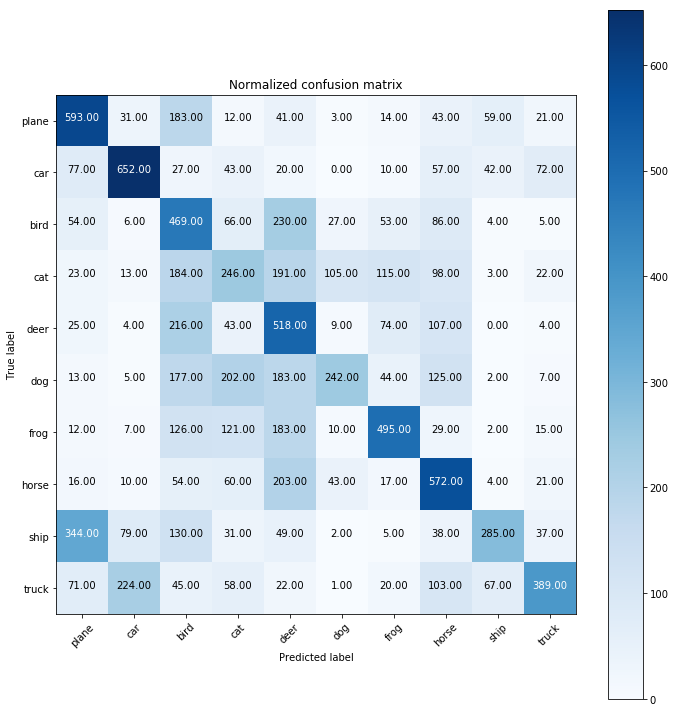

In [23]:
for epoch in range(1, 1 + 1):
    test(model, 'cpu', testloader)

# Scratch Note

In [13]:
target = torch.tensor([3, 2 ,2, 4], dtype=torch.long)
pred = torch.tensor([8,2,2,4], dtype=torch.long)

In [14]:
y_test = list(target)
y_pred = list(pred)

[[2 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]


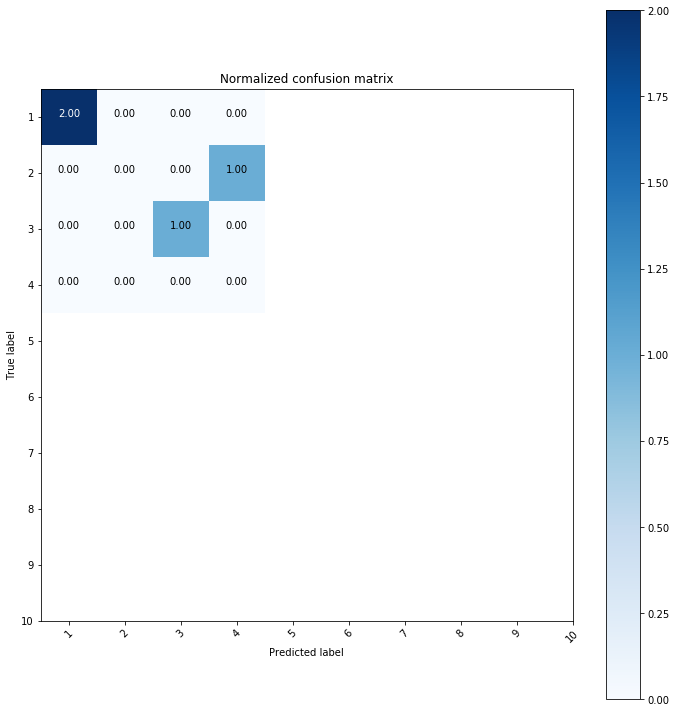

In [15]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                      title='Normalized confusion matrix')
